In [ ]:
!pip install numpyro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.2/348.2 kB 3.8 MB/s eta 0:00:00


In [ ]:

import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import numpy as np
import jax.numpy as jnp
from jax import random
from jax import vmap
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.rc('font',family ='Arial',size=10)
import pandas as pd
import seaborn as sns
from jax.scipy.stats import norm

# GOH
Gasser et al 2006(https://doi.org/10.1098/rsif.2005.0073)


Incompressible material assumption
$$\Psi_1(J) = p(1-J)$$
$$\Psi_2(\mathbf{C}) = \frac{\mu}{2}(I_1 -3) +\frac{k_1}{2k_2}[e^{(k_2[\kappa I_1 + (1-3\kappa)I_4-1]^2)}-1]$$
Here $I_4 = \mathbf{C}:\mathbf{M} =\mathbf{C}:  \mathbf{a}_0\otimes \mathbf{a}_0$

Let $\mathbf{H} =\kappa \mathbf{I} + (1-3\kappa)\mathbf{M}$

and $H = \mathbf{H}:\mathbf{C}  =\kappa I_1 + (1-3\kappa)I_4$ and $E = [{H}-1]$

$$\mathbf{S}_1  = 2\frac{\partial \Psi_{1}}{\partial \mathbf{C}} = -pC^{-1} $$
$$\mathbf{S}_2  =  2\frac{\partial \Psi_{2}}{\partial \mathbf{C}} = \mu \mathbf{I} + 2k_1 e^{k_2{E}^2}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK2 stress

$$\mathbf{S} = -p\mathbf{C}^{-1} +  \mu\mathbf{I} + 2k_1 e^{k_2{E}^2}{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK1 stress

$$\mathbf{P} = \mathbf{F}\mathbf{S}$$

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#### Here,the function to evaluate the stress considering the GOH model with two groups of fibers

def GOH(par, lmx, lmy, lmz):
    mu, k1, k2, kappa, alpha, k1_2, k2_2, kappa2, alpha2 = par
    mu = 0.05*(jnp.tanh(mu)+1)/2
    k1 = 100*(jnp.tanh(k1)+1)/2
    k2 = 1000*(jnp.tanh(k2)+1)/2
    kappa = 0.33*(jnp.tanh(kappa)+1)/2
    k1_2 = 100*(jnp.tanh(k1_2)+1)/2
    k2_2 = 1000*(jnp.tanh(k2_2)+1)/2
    kappa2 = 0.33*(jnp.tanh(kappa2)+1)/2

    # mu = 0.05*norm.cdf(mu)
    # k1 = 100*norm.cdf(k1)
    # k2 = 1000*norm.cdf(k2)
    # kappa = 0.33*(jnp.tanh(kappa)+1)/2
    # k1_2 = 100*norm.cdf(k1_2)
    # k2_2 = 1000*norm.cdf(k2_2)
    # kappa2 = 0.33*(jnp.tanh(kappa2)+1)/2


    a1 = jnp.array([jnp.cos(alpha),jnp.sin(alpha),0])
    a2 = jnp.array([jnp.cos(alpha2),jnp.sin(alpha2),0])
    M1 = jnp.outer(a1,a1)
    M2 = jnp.outer(a2,a2)

    F = jnp.array([[lmx, 0, 0],
                    [0, lmy, 0],
                    [0, 0, lmz]])
    C = jnp.dot(F.T,F)
    invC = jnp.linalg.inv(C)
    I = jnp.eye(3)
    I1 = C[0,0] + C[1,1] + C[2,2]  ## trace of C
    I4 = jnp.tensordot(C,M1)
    I4_2 = jnp.tensordot(C,M2)

    H1 = kappa*I1+(1-3*kappa)*I4
    H2 = kappa2*I1+(1-3*kappa2)*I4_2
    E1 = H1-1.0
    E2 = H2-1
    S2 = mu*I+2*k1*jnp.exp(k2*E1**2)*E1*(kappa*I+(1-3*kappa)*M1)+2*k1_2*jnp.exp(k2_2*E2**2)*E2*(kappa2*I+(1-3*kappa2)*M2)
    p = S2[2,2]/invC[2,2]
    S = -p*invC+S2

    sgm = jnp.dot(F,jnp.dot(S,F.T))

    return sgm[0,0], sgm[1,1]

GOH_vmap = vmap(GOH, in_axes=(0,0,0,0), out_axes=(0,0))
GOH_vmap2 = vmap(GOH, in_axes=(None,0,0,0), out_axes=(0,0))

In [ ]:
# Load the data
OffX_5XCL1      = pd.read_csv('XR/OffX_5XCL.csv').to_numpy()[:,1:]
OffX_5XCR1    = pd.read_csv('XR/OffX_5XCR.csv').to_numpy()[:,1:]
OffX_3XC1    = pd.read_csv('XR/OffX_3XC.csv').to_numpy()[:,1:]
OffX_6XC1 = pd.read_csv('XR/OffX_6XC.csv').to_numpy()[:,1:]
OffX_PennyXRT1 = pd.read_csv('XR/OffX_PennyXR.csv').to_numpy()[:,1:]
OffX_BubblesXR1 = pd.read_csv('XR/OffX_BubblesXR.csv').to_numpy()[:,1:]

OffY_5XCL1      = pd.read_csv('XR/OffY_5XCL').to_numpy()[:,1:]
OffY_5XCR1    = pd.read_csv('XR/OffY_5XCR').to_numpy()[:,1:]
OffY_3XC1    = pd.read_csv('XR/OffY_3XC.csv').to_numpy()[:,1:]
OffY_6XC1 = pd.read_csv('XR/OffY_6XC').to_numpy()[:,1:]
OffY_PennyXRT1 = pd.read_csv('XR/OffY_PennyXR').to_numpy()[:,1:]
OffY_BubblesXR1 = pd.read_csv('XR/OffY_BubblesXR').to_numpy()[:,1:]

vecze  = jnp.ones((len(OffX_5XCL1),1))
vecze2 = jnp.ones((len(OffX_5XCR1),1))
vecze3 = jnp.ones((len(OffX_3XC1),1))
vecze4 = jnp.ones((len(OffX_6XC1),1))
vecze5 = jnp.ones((len(OffX_PennyXRT1),1))
vecze6 = jnp.ones((len(OffX_BubblesXR1),1))

vecze11  = jnp.ones((len(OffY_5XCL1),1))
vecze22 = jnp.ones((len(OffY_5XCR1),1))
vecze33 = jnp.ones((len(OffY_3XC1),1))
vecze44 = jnp.ones((len(OffY_6XC1),1))
vecze55 = jnp.ones((len(OffY_PennyXRT1),1))
vecze66 = jnp.ones((len(OffY_BubblesXR1),1))


OffX_5XCL       = jnp.hstack([0*vecze,OffX_5XCL1,0*vecze])
OffX_5XCR     = jnp.hstack([1*vecze2,OffX_5XCR1,0*vecze2])
OffX_3XC     = jnp.hstack([2*vecze3,OffX_3XC1,0*vecze3])
OffX_6XC  = jnp.hstack([3*vecze4,OffX_6XC1,0*vecze4])
OffX_PennyXRT = jnp.hstack([4*vecze5,OffX_PennyXRT1,0*vecze5])
OffX_BubblesXR = jnp.hstack([5*vecze6,OffX_BubblesXR1,0*vecze6])


OffY_5XCL       = jnp.hstack([0*vecze11,OffY_5XCL1,1*vecze11])
OffY_5XCR     = jnp.hstack([1*vecze22,OffY_5XCR1,1*vecze22])
OffY_3XC     = jnp.hstack([2*vecze33,OffY_3XC1,1*vecze33])
OffY_6XC  = jnp.hstack([3*vecze44,OffY_6XC1,1*vecze44])
OffY_PennyXRT = jnp.hstack([4*vecze55,OffY_PennyXRT1,1*vecze55])
OffY_BubblesXR = jnp.hstack([5*vecze66,OffY_BubblesXR1,1*vecze66])


OffXall = jnp.vstack([OffX_5XCL,
                      OffX_5XCR,
                      OffX_3XC,
                      OffX_6XC,
                      OffX_PennyXRT,
                      OffX_BubblesXR
                  ]).T

OffYall = jnp.vstack([OffY_5XCL,
                      OffY_5XCR,
                      OffY_3XC,
                      OffY_6XC,
                      OffY_PennyXRT,
                      OffY_BubblesXR
                  ]).T

OffXandY=jnp.hstack([OffXall,OffYall])

n_samples=8
data = np.zeros([6,jnp.shape(OffXandY)[1]]) # data: [sample id, lambda_x, lambda_y, sigma_xx, sigma_yy, boolean(0 for OffX, 1 OffY)] <-- contains this variables as columns

data[0,:]=OffXandY[0,:]
data[1,:]=OffXandY[1,:]
data[2,:]=OffXandY[3,:]
data[3,:]=OffXandY[2,:]
data[4,:]=OffXandY[4,:]
data[5,:]=OffXandY[5,:]

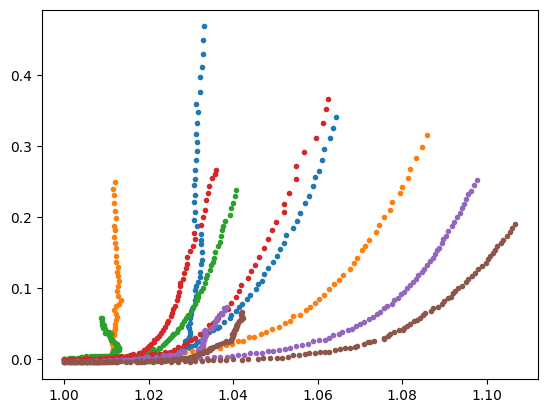

In [ ]:
for i_sample in [0,1,2,3,4,5]:
    sample_lmx  = data[1,data[0,:]==i_sample]
    sample_lmy  = data[2,data[0,:]==i_sample]
    sample_sgmx = data[3,data[0,:]==i_sample]
    sample_sgmy = data[4,data[0,:]==i_sample]
    plt.plot(sample_lmy, sample_sgmy, '.')

    ##change the order mechanics orientation histology

# Sección nueva

In [ ]:
n_params = 9
def model(i_sample, lmx, lmy, sgmx_gt=None, sgmy_gt=None):
    # Individual parameters
    L_i = numpyro.sample('L_i', dist.Normal(0,1), sample_shape=(n_params,n_params))
    K_i = L_i @ L_i.T
    mu_i = numpyro.sample('mu_i', dist.Normal(0,1), sample_shape=(n_params,))
    with numpyro.plate('plate_i', n_samples):
        params_i = numpyro.sample('params_i', dist.MultivariateNormal(mu_i, K_i))

    lmz = 1.0/(lmx*lmy)
    sgmx_pr, sgmy_pr = GOH_vmap(params_i[i_sample], lmx, lmy, lmz)
    sgm_noise = numpyro.sample('sgm_noise', dist.HalfNormal(0.005))
    with numpyro.plate('data', len(lmx)):
        numpyro.sample('obs_sgmx', dist.Normal(sgmx_pr,sgm_noise), obs=sgmx_gt)
        numpyro.sample('obs_sgmy', dist.Normal(sgmy_pr,sgm_noise), obs=sgmy_gt)

In [ ]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000) # use 20000 and 200000
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, data[0,:].astype(int), data[1,:], data[2,:], data[3,:], data[4,:])

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [47:56<00:00,  1.39it/s, 1023 steps of size 5.87e-07. acc. prob=0.87]


In [ ]:
# posterior_samples['params_i'][0]
np.shape(posterior_samples["params_i"])

(2000, 8, 9)

In [ ]:
sam1=posterior_samples["params_i"][:,0,:]
XRT1d = pd.DataFrame(data=sam1, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
XRT1d.to_csv('XRT1.csv')

sam2=posterior_samples["params_i"][:,1,:]
XRT2d = pd.DataFrame(data=sam2, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
XRT2d.to_csv('XRT2.csv')

sam3=posterior_samples["params_i"][:,2,:]
XRT3d = pd.DataFrame(data=sam3, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
XRT3d.to_csv('XRT3.csv')

sam4=posterior_samples["params_i"][:,3,:]
XRT4d = pd.DataFrame(data=sam4, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
XRT4d.to_csv('XRT4.csv')

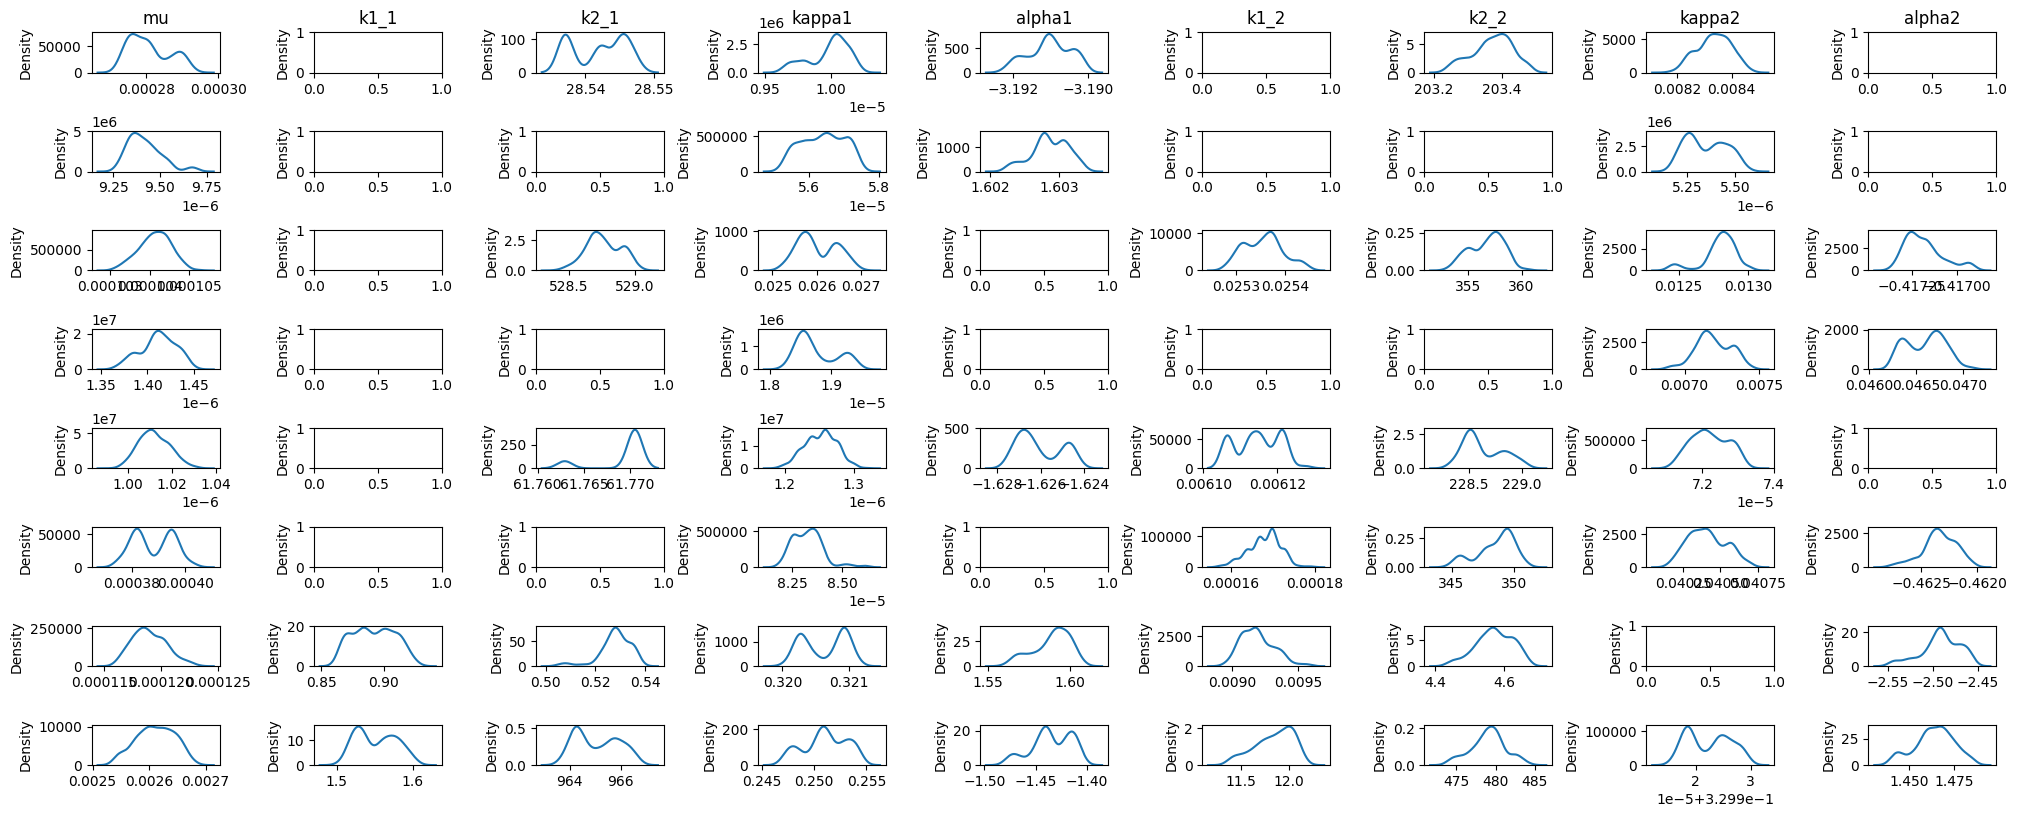

In [ ]:
fig, ax = plt.subplots(8, 9, figsize=(20, 8))

for i in range(8):

    sns.kdeplot(np.array(0.05*(jnp.tanh((posterior_samples["params_i"][:, i, 0]))+1)/2), ax=ax[i,0], bw_method=0.3, label='', warn_singular=False)
    sns.kdeplot(np.array(99*(jnp.tanh((posterior_samples["params_i"][:, i, 1]))+1)/2), ax=ax[i,1], bw_method=0.3, warn_singular=False)
    sns.kdeplot(np.array(1000*(jnp.tanh((posterior_samples["params_i"][:, i, 2]))+1)/2), ax=ax[i,2], bw_method=0.3, warn_singular=False)
    sns.kdeplot(np.array(0.33*(jnp.tanh((posterior_samples["params_i"][:, i, 3]))+1)/2), ax=ax[i,3], bw_method=0.3, warn_singular=False)
    sns.kdeplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4], bw_method=0.3, warn_singular=False)
    sns.kdeplot(np.array(100*(jnp.tanh((posterior_samples["params_i"][:, i, 5]))+1)/2), ax=ax[i,5], bw_method=0.3, warn_singular=False)
    sns.kdeplot(np.array(1000*(jnp.tanh((posterior_samples["params_i"][:, i, 6]))+1)/2), ax=ax[i,6], bw_method=0.3, warn_singular=False)
    sns.kdeplot(np.array(0.33*(jnp.tanh((posterior_samples["params_i"][:, i, 7]))+1)/2), ax=ax[i,7], bw_method=0.3, warn_singular=False)
    sns.kdeplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8], bw_method=0.3, warn_singular=False)

    # sns.kdeplot(np.array(0.05*norm.cdf(posterior_samples["params_i"][:, i, 0])), ax=ax[i,0], bw_method=0.3, warn_singular=False)
    # sns.kdeplot(np.array(99*norm.cdf(posterior_samples["params_i"][:, i, 1])), ax=ax[i,1], bw_method=0.3, warn_singular=False)
    # sns.kdeplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 2])), ax=ax[i,2], bw_method=0.3, warn_singular=False)
    # sns.kdeplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 3])), ax=ax[i,3], bw_method=0.3, warn_singular=False)
    # sns.kdeplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4], bw_method=0.1, warn_singular=False)
    # sns.kdeplot(np.array(100*norm.cdf(posterior_samples["params_i"][:, i, 5])), ax=ax[i,5], bw_method=0.3, warn_singular=False)
    # sns.kdeplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 6])), ax=ax[i,6], bw_method=0.3, warn_singular=False)
    # sns.kdeplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 7])), ax=ax[i,7], bw_method=0.3, warn_singular=False)
    # sns.kdeplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8], bw_method=0.6, warn_singular=False)

# sns.kdeplot(data2, ax=ax[1,1], label='Distribution 2')

ax[0,0].set_title('mu')
ax[0,1].set_title('k1_1')
ax[0,2].set_title('k2_1')
ax[0,3].set_title('kappa1')
ax[0,4].set_title('alpha1')
ax[0,5].set_title('k1_2')
ax[0,6].set_title('k2_2')
ax[0,7].set_title('kappa2')
ax[0,8].set_title('alpha2')

# ax[2,3].spines['left'].set_visible(False)
# ax[0,8].spines['top'].set_visible(False)

# ax[0,0].legend()
# ax[1,0].legend()
# ax[0,1].legend()
# ax[1,1].legend()

# # plt.legend()
# plt.savefig("PosteriorParams_iCTRL.png",dpi=300)
fig.tight_layout(pad=0.1)

plt.show()

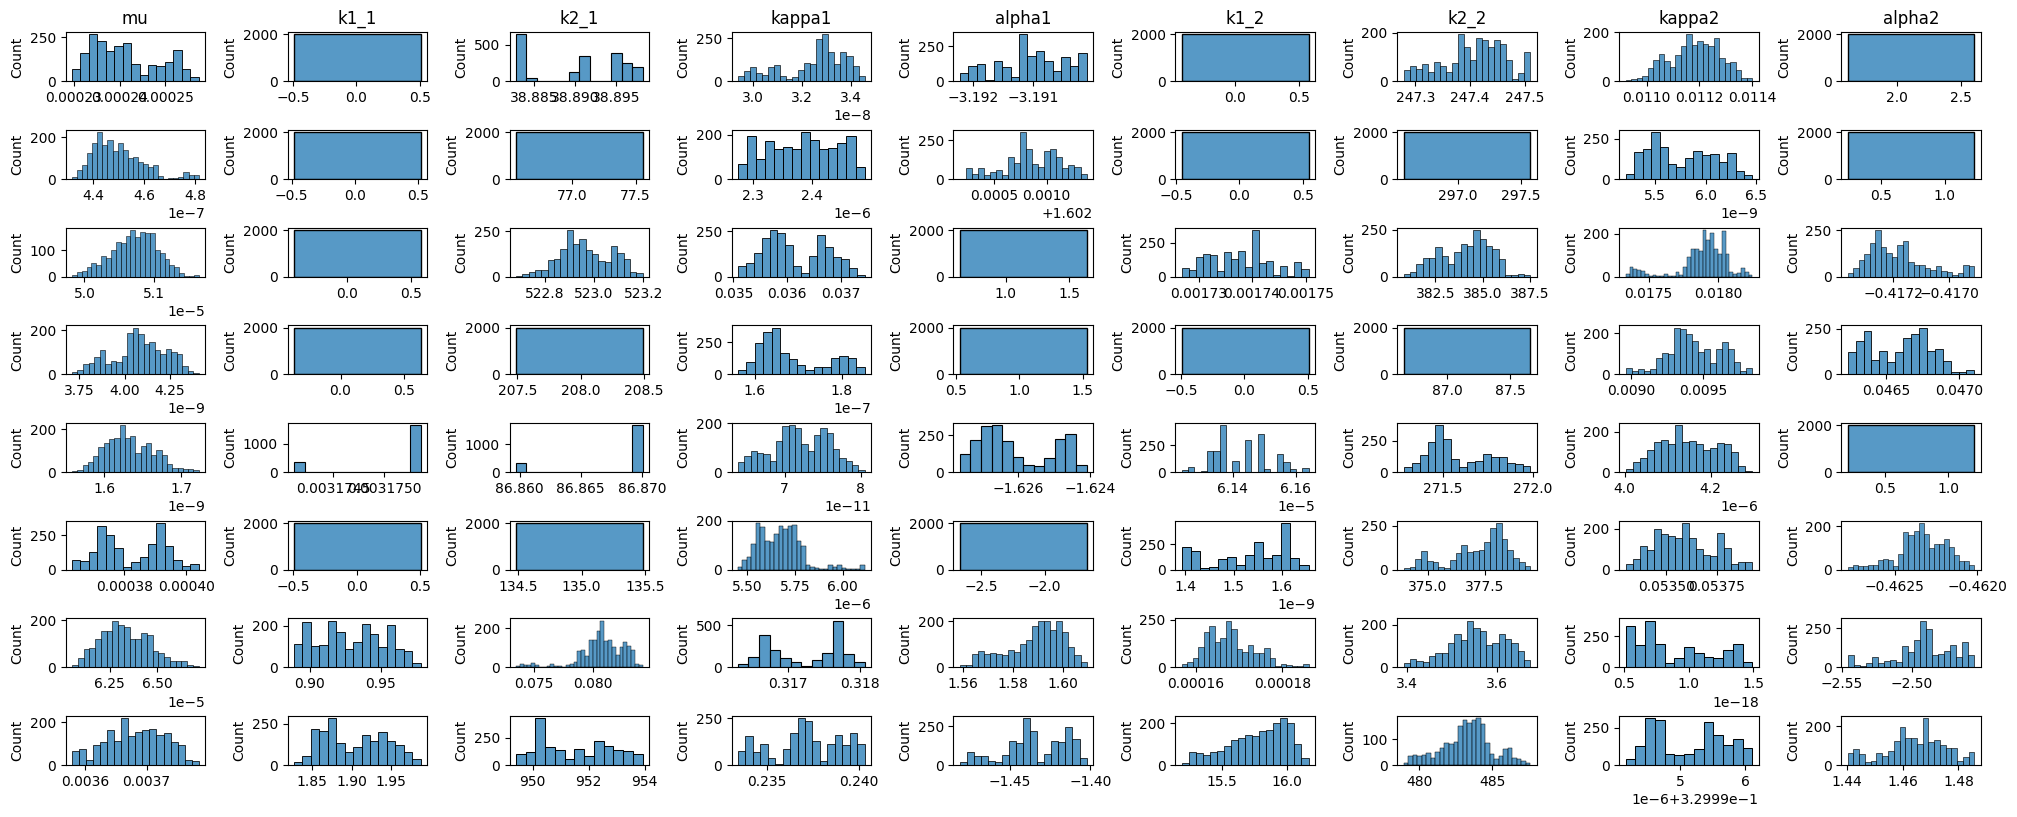

In [ ]:
fig, ax = plt.subplots(8, 9, figsize=(20, 8))

for i in range(8):
    # sns.histplot(np.array(0.05*(jnp.tanh((posterior_samples["params_i"][:, i, 0]))+1)/2), ax=ax[i,0])
    # sns.histplot(np.array(99*(jnp.tanh((posterior_samples["params_i"][:, i, 1]))+1)/2), ax=ax[i,1])
    # sns.histplot(np.array(1000*(jnp.tanh((posterior_samples["params_i"][:, i, 2]))+1)/2), ax=ax[i,2])
    # sns.histplot(np.array(0.33*(jnp.tanh((posterior_samples["params_i"][:, i, 3]))+1)/2), ax=ax[i,3])
    # sns.histplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4])
    # sns.histplot(np.array(100*(jnp.tanh((posterior_samples["params_i"][:, i, 5]))+1)/2), ax=ax[i,5])
    # sns.histplot(np.array(1000*(jnp.tanh((posterior_samples["params_i"][:, i, 6]))+1)/2), ax=ax[i,6])
    # sns.histplot(np.array(0.33*(jnp.tanh((posterior_samples["params_i"][:, i, 7]))+1)/2), ax=ax[i,7])
    # sns.histplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8])

    sns.histplot(np.array(0.05*norm.cdf(posterior_samples["params_i"][:, i, 0])), ax=ax[i,0])
    sns.histplot(np.array(99*norm.cdf(posterior_samples["params_i"][:, i, 1])), ax=ax[i,1])
    sns.histplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 2])), ax=ax[i,2])
    sns.histplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 3])), ax=ax[i,3])
    sns.histplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4])
    sns.histplot(np.array(100*norm.cdf(posterior_samples["params_i"][:, i, 5])), ax=ax[i,5])
    sns.histplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 6])), ax=ax[i,6])
    sns.histplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 7])), ax=ax[i,7])
    sns.histplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8])


# sns.kdeplot(data2, ax=ax[1,1], label='Distribution 2')

ax[0,0].set_title('mu')
ax[0,1].set_title('k1_1')
ax[0,2].set_title('k2_1')
ax[0,3].set_title('kappa1')
ax[0,4].set_title('alpha1')
ax[0,5].set_title('k1_2')
ax[0,6].set_title('k2_2')
ax[0,7].set_title('kappa2')
ax[0,8].set_title('alpha2')

# ax[2,3].spines['left'].set_visible(False)
# ax[0,8].spines['top'].set_visible(False)

# ax[0,0].legend()
# ax[1,0].legend()
# ax[0,1].legend()
# ax[1,1].legend()

# # plt.legend()
# plt.savefig("PosteriorParams_iCTRL.png",dpi=300)
fig.tight_layout(pad=0.1)

In [ ]:
TableM=np.zeros((6,9))
print(np.shape(TableM))
for i in range(6):
    for j in range(9):
        x=posterior_samples['params_i'][:,i,j]
        if j!=4 and j!=8:
            if j==3 or j==7:
                for m in range(len(x)):
                    x = x.at[m].set(0.33*(jnp.tanh(x[m])+1)/2)
            elif j==1 or j==5:
                for m in range(len(x)):
                    x = x.at[m].set(100*(jnp.tanh(x[m])+1)/2)
            elif j==2 or j==6:
                for m in range(len(x)):
                    x = x.at[m].set(1000*(jnp.tanh(x[m])+1)/2)
            elif j==0:
                for m in range(len(x)):
                    x = x.at[m].set(0.05*(jnp.tanh(x[m])+1)/2)
            # else:
            #     for m in range(len(x)):
            #         x = x.at[m].set(jnp.exp(x[m]))

        TableM[i,j]=np.median(x)
        # TableM[i,j]=np.median(x)

print(TableM)

# CTRLcsv = pd.DataFrame(data=TableM, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
# CTRLcsv.to_csv('CTRLcsv.csv')

# XRTcsv = pd.DataFrame(data=TableM, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
# # XRTcsv.to_csv('XRTcsv.csv')


# XRTcsv = pd.DataFrame(data=TableM, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
# XRTcsv.to_csv('XRTcsv.csv')
# x=posterior_samples['params_i'][:,1,1]
# print(np.median(x)) #distribution of the posterior for the 1st skin sample for the parameter mu.
# n, bins, patches = plt.hist(x)
# plt.show()

(6, 9)
[[ 2.79747706e-04  5.20139933e-02  2.85424595e+01  1.00314619e-05
  -3.19104004e+00  1.79046392e-01  2.03379990e+02  8.33830424e-03
   2.10841846e+00]
 [ 9.39965230e-06  8.18014145e-02  5.46644325e+01  5.64663133e-05
   1.60284150e+00  1.31121278e-01  2.56228302e+02  5.34027822e-06
   7.34451473e-01]
 [ 1.04156141e-04  1.81022286e-01  5.28748779e+02  2.58920882e-02
   1.13733840e+00  2.53587961e-02  3.56999329e+02  1.28150061e-02
  -4.17203128e-01]
 [ 1.41263013e-06  2.45794654e-01  1.64262802e+02  1.86221296e-05
   1.03153610e+00  4.34607267e-02  6.19825706e+01  7.18180416e-03
   4.66355905e-02]
 [ 1.01178887e-06  3.37332487e-02  6.17705269e+01  1.25885015e-06
  -1.62640214e+00  6.11543655e-03  2.28567505e+02  7.21576871e-05
   7.08083212e-01]
 [ 3.86802858e-04  4.36753035e-02  9.91871338e+01  8.32513033e-05
  -2.16864347e+00  1.69873238e-04  3.48977783e+02  4.04030085e-02
  -4.62335140e-01]]


In [ ]:
predictive = Predictive(model, posterior_samples)
samples_predictive = predictive(random.PRNGKey(1), data[0,:].astype(int), data[1,:], data[2,:], None, None)

(74,)
err
0.0001027399
(74,)
err
0.00011637851
(74,)
err
1.06787575e-05
(62,)
err
0.00036580194
(100,)
err
3.3687743e-06
(100,)
err
6.8516947e-06
(981,)
(981,)
(981,)
(981,)
(981,)
(981,)


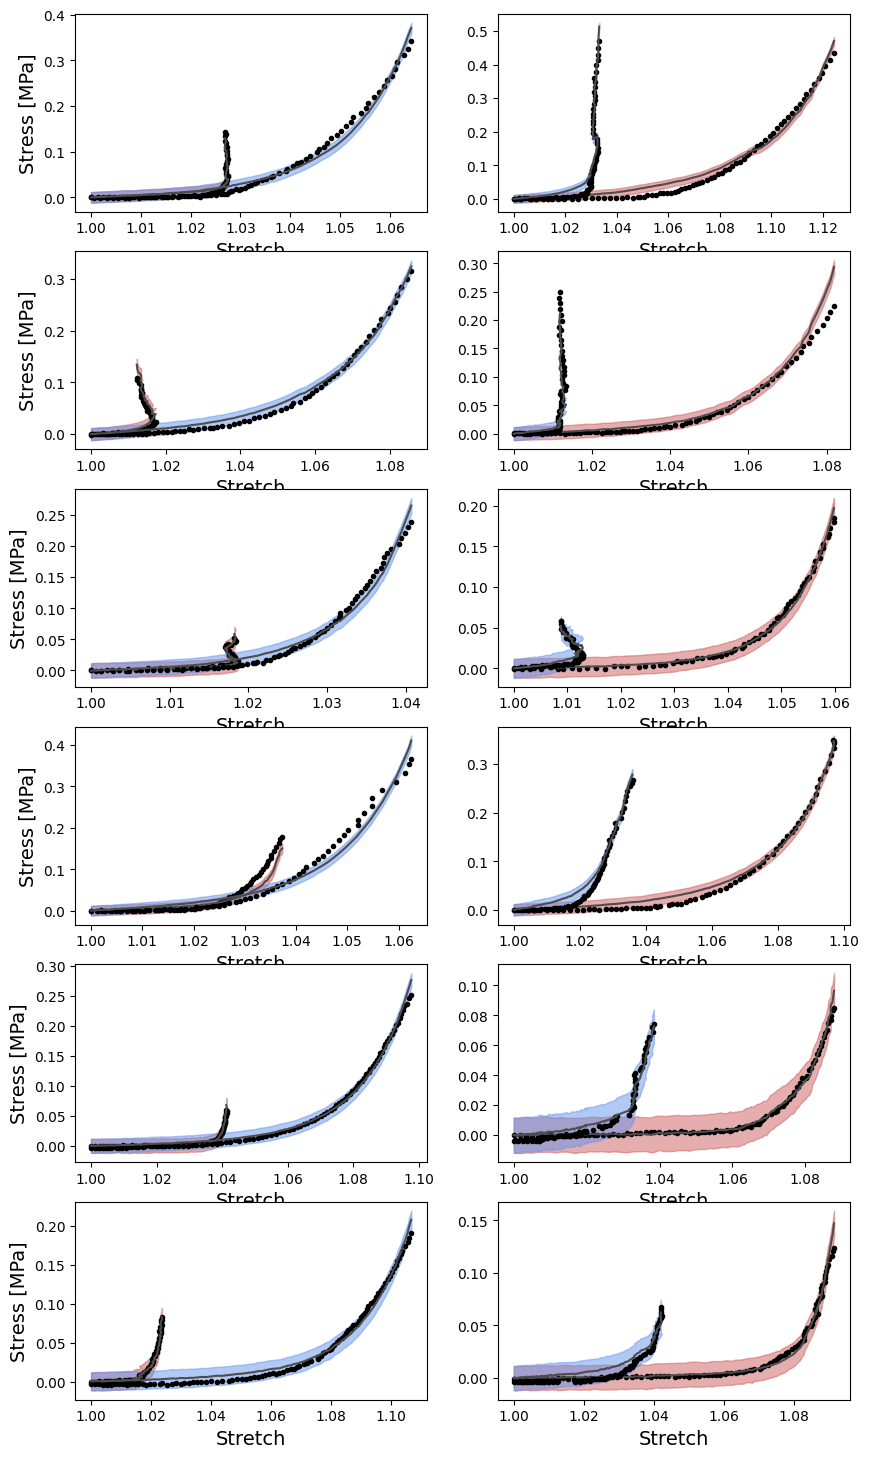

In [ ]:
fig, axes = plt.subplots(6,2,figsize=(10,18))

for ax, i_sample in zip(axes, [0,1,2,3,4,5]):

    idx = (data[0,:]==i_sample) & (data[5,:]==0)
    sgmx_pr = samples_predictive['obs_sgmx']
    sgmy_pr = samples_predictive['obs_sgmy']
    # print(np.shape(sgmx_pr))
    # print(idx)
    x = data[1,idx]
    y = data[2,idx]
    # print(x)
    sgmx_gt = data[3,idx] ##sigma real
    sgmx_std = sgmx_pr.std(axis=0)[idx]
    sgmx_pr = sgmx_pr.mean(axis=0)[idx]
    sgmx_inf = sgmx_pr-sgmx_std
    sgmx_sup = sgmx_pr+sgmx_std
    print(np.shape(sgmx_pr))

    err=0
    for i in range(0,len(sgmx_gt)):
        err += (sgmx_gt[i]-sgmx_pr[i])**2
    # print('err')
    # print(err/len(sgmx_gt))

    # pd.DataFrame(sgmx_pr).to_csv('/Users/lnunezal/Library/CloudStorage/OneDrive-purdue.edu/Tepole Lab/R01 project/PSF calib/sgmx_gtOFFX'+str(i_sample)+'.csv')
    # pd.DataFrame(sgmy_pr).to_csv('/Users/lnunezal/Library/CloudStorage/OneDrive-purdue.edu/Tepole Lab/R01 project/PSF calib/sgmy_gtOFFX'+str(i_sample)+'.csv')

    # if np.all(data[5,:]==0):
    ax[0].plot(x,sgmx_gt,'.', color='0')
    ax[0].plot(x,sgmx_pr,color='0.3')
    ax[0].fill_between(x, sgmx_sup, sgmx_inf, alpha=0.5, color='indianred') # X AXIS CORRESPOND TO ANTERIOR - POSTERIOR
    ax[0].set_ylabel('Stress [MPa]', size=14)
    ax[0].set_xlabel(xlabel='Stretch', size=14)
    # ax[0].set(xlabel='$\lambda_y$', ylabel='$\sigma_{xx}$')

    sgmy_gt = data[4,idx]
    sgmy_std = sgmy_pr.std(axis=0)[idx]
    sgmy_pr = sgmy_pr.mean(axis=0)[idx]
    sgmy_inf = sgmy_pr-sgmy_std
    sgmy_sup = sgmy_pr+sgmy_std
    ax[0].plot(y,sgmy_gt,'.', color='0')
    ax[0].plot(y,sgmy_pr, color='0.3')
    ax[0].fill_between(y, sgmy_sup, sgmy_inf, alpha=0.5, color='cornflowerblue') # Y AXIS CORRESPOND TO DORSAL - VENTRAL
    ax[0].set_xlabel(xlabel='Stretch', size=14)
        # ax[1].set(xlabel='$\lambda_y$', ylabel='$\sigma_{yy}$')

for ax, i_sample in zip(axes, [0,1,2,3,4,5]):
    idx = (data[0,:]==i_sample) & (data[5,:]==1)
    sgmx_pr = samples_predictive['obs_sgmx']
    sgmy_pr = samples_predictive['obs_sgmy']
    print(np.shape(idx))
    x = data[1,idx]
    y = data[2,idx]
    # print(x)
    sgmx_gt = data[3,idx] ##sigma real
    sgmx_std = sgmx_pr.std(axis=0)[idx]
    sgmx_pr = sgmx_pr.mean(axis=0)[idx]
    sgmx_inf = sgmx_pr-sgmx_std
    sgmx_sup = sgmx_pr+sgmx_std

    ax[1].plot(x,sgmx_gt,'.', color='0')
    ax[1].plot(x,sgmx_pr,color='0.3')
    ax[1].fill_between(x, sgmx_sup, sgmx_inf, alpha=0.5, color='indianred')
    # ax[1].set_ylabel('Stress [MPa]', size=14)
    ax[1].set_xlabel(xlabel='Stretch', size=14)
    # ax[0].set(xlabel='$\lambda_y$', ylabel='$\sigma_{xx}$')


    sgmy_gt = data[4,idx]
    sgmy_std = sgmy_pr.std(axis=0)[idx]
    sgmy_pr = sgmy_pr.mean(axis=0)[idx]
    sgmy_inf = sgmy_pr-sgmy_std
    sgmy_sup = sgmy_pr+sgmy_std
    ax[1].plot(y,sgmy_gt,'.', color='0')
    ax[1].plot(y,sgmy_pr, color='0.3')
    ax[1].fill_between(y, sgmy_sup, sgmy_inf, alpha=0.5, color='cornflowerblue')
    ax[1].set_xlabel(xlabel='Stretch', size=14)
    # ax[1].set(xlabel='$\lambda_y$', ylabel='$\sigma_{yy}$')

    # pd.DataFrame(sgmx_pr).to_csv('/Users/lnunezal/Library/CloudStorage/OneDrive-purdue.edu/Tepole Lab/R01 project/PSF calib/sgmx_gtOFFY'+str(i_sample)+'.csv')
    # pd.DataFrame(sgmy_pr).to_csv('/Users/lnunezal/Library/CloudStorage/OneDrive-purdue.edu/Tepole Lab/R01 project/PSF calib/sgmy_gtOFFY'+str(i_sample)+'.csv')


# fig.suptitle('XR data', fontsize= 20)
# plt.savefig("XR_data_i2_2",dpi=300)

plt.show()



In [ ]:
np.shape(posterior_samples['params_i'])
# sgmx_pr.mean(axis=0)[]

[-3.0859027 -3.553911  -1.4251634 -4.3365955  1.1373384 -3.3177547
 -0.5328326 -1.8263204  0.7344515]


Text(0.5, 0.98, 'XR data')

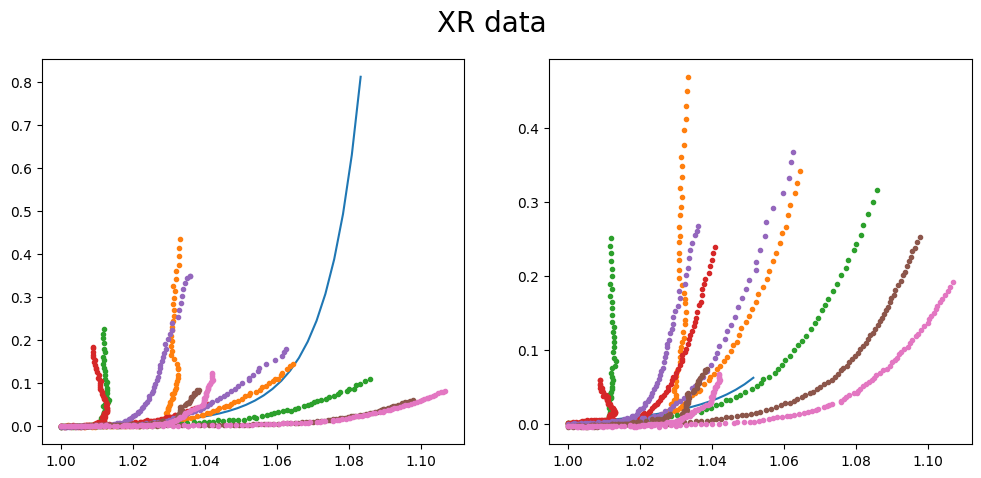

In [ ]:
params_i = posterior_samples['params_i']
params_i = params_i[:,:3,:]
params_i = params_i.reshape([-1,9])
params_i = np.median(params_i,axis=0)
print(params_i)

# plot with the median of params_g
lmy = np.linspace(1.0,1.12)
lmx = np.sqrt(lmy)
lmz = 1.0/(lmx*lmy)

sgmx_pr, sgmy_pr = GOH_vmap2(params_i, lmx, lmy, lmz)

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(lmy[0:-15],sgmx_pr[0:-15])
ax[1].plot(lmy[0:-28],sgmy_pr[0:-28])

for i_sample in [0,1,2,3,4,5,6,7]:

    idx = data[0,:]==i_sample
    x = data[2,idx]
    # print(x)
    sgmx_gt = data[3,idx] ##sigma real

    sgmy_gt = data[4,idx]
    ax[1].plot(x,sgmy_gt,'.')
    ax[0].plot(x,sgmx_gt,'.')

fig.suptitle('XR data', fontsize= 20)
# plt.savefig("XR_data_pred",dpi=300)

In [ ]:
predictive = Predictive(model, posterior_samples)
samples_predictive2 = predictive(random.PRNGKey(1), None, data[1,:], data[2,:], None, None)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

sgmx_pr = samples_predictive2['obs1'] # predicted P11 value
sgmy_pr = samples_predictive2['obs2'] # predicted P22 value

idx = data[0,:]==i_sample # idx is the vector that contains all data points from the same i_sample (sample id)
x = data[2,idx] # all the lam1 values from the same sample
sgmx_gt = data[3,idx] # all the P11 values from the same sample
sgmx_std = sgmx_pr.std(axis=0)[idx] # std of predicted P11
sgmx_pr = sgmx_pr.mean(axis=0)[idx] # mean value of predicted P11
sgmx_inf = sgmx_pr-sgmx_std*2 # lower bound CI
sgmx_sup = sgmx_pr+sgmx_std*2 # upper bound CI

ax[0].plot(x,sgmx_gt,'.', color='0') # plot real data P11 vs lam1
ax[0].plot(x,sgmx_pr) # plot predicted P11 vs lam1
# ax[0].fill_between(x[::10], sgmx_sup[::10], sgmx_inf[::10], alpha=0.5) # Fill CI
ax[0].set(xlabel='$\lambda_y$', ylabel='$\sigma_{xx}$')

sgmy_gt = data[4,idx] # all the P22 values from the same sample
sgmy_std = sgmy_pr.std(axis=0)[idx] # std of predicted P22
sgmy_pr = sgmy_pr.mean(axis=0)[idx] # mean value of predicted P22
sgmy_inf = sgmy_pr-sgmy_std*2
sgmy_sup = sgmy_pr+sgmy_std*2

ax[1].plot(x,sgmy_gt,'.', color='0')
ax[1].plot(x[0:-5],sgmy_pr[0:-5])
# ax[1].fill_between(x[::10], sgmy_sup[::10], sgmy_inf[::10], alpha=0.5)
ax[1].set(xlabel='$\lambda_y$', ylabel='$\sigma_{yy}$')

for i_sample in range(n_samples):
    idx = data[0,:]==i_sample
    sgmx_gt = data[3,idx]
    sgmy_gt = data[4,idx]
    if len(x)<len(sgmx_gt):
        ax[0].plot(x,sgmx_gt[0:len(x)],'.')
        ax[1].plot(x,sgmy_gt[0:len(x)],'.')
    elif len(x)>len(sgmx_gt):
        ax[0].plot(x[0:len(sgmx_gt)],sgmx_gt,'.')
        ax[1].plot(x[0:len(sgmy_gt)],sgmy_gt,'.')